# Bonus Quest

**Difficulty:** A

**Description:** Students are in a tough spot after changing the grading formula for assignments and now fear taking the exam without a 3.5 GPA. The system gives players a chance to raise their score by completing this bonus quest. This is your Solo Leveling. Survive at all costs. Good luck!

**Goal:** Complete the bonus assignment created by Andrei and corrected by Max.

**Deliverables:**
- Jupyter Notebook (ipynb) file with solution and all cell outputs
- CSV file with model predictions
- Both files uploaded to GitHub repository

**Reward:**
- Bonus points for the Assignment part.
- Title “The one who overcomes the difficulties of fate.”
- +1000 EXP in mastering sklearn
- Skill Upgrade «ML Engineering Lv.2»
- Special Item: [???]

---

## Problem Statement

As a dataset, use Russian news from Balto-Slavic Natural Language Processing 2019 (helsinki.fi). Entities of interest: PER, ORG, LOC, EVT, PRO (see Guidelines_20190122.pdf (helsinki.fi)).

It is sufficient to use 9 documents about Brexit from the sample provided by the organizers.

## Approach

This assignment combines traditional ML methods (using scikit-learn) with modern LLM-based approaches (DeepSeek) for comparison. You will:
1. Formulate the problem as a machine learning task
2. Prepare features and split data appropriately
3. Train and compare multiple models using scikit-learn
4. Evaluate models using proper train/test splits
5. Compare ML model performance with DeepSeek responses
6. Analyze results in terms of course concepts (bias-variance tradeoff, overfitting, generalization)


Example of one document:

ru-10

ru

2018-09-20

https://rg.ru/2018/09/20/tereza-mej-rasschityvaet-usidet-v-sedle-do-zaversheniia-procedury-brexit.html

Theresa May expects to stay in the saddle until the completion of the Brexit procedure
However, according to British media reports, at the upcoming Conservative Party conference at the end of September, May's opponents will give her a serious fight, from which it is not certain that she will emerge victorious. The bookmakers' favorite as a possible replacement for the current prime minister, former British Foreign Secretary Boris Johnson intends to deliver an alternative report that will leave no stone unturned from the government's views on the conditions of "Brexit". From Johnson's point of view, "London has wrapped the British constitution in a suicide belt and handed the detonator to Michel Barnier (Brussels' chief Brexit negotiator. - Ed.)". It is with this metaphor that the head of the British government will have to fight at the conference.


In [15]:
import os
import re
import json
import zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
RANDOM_STATE = 1
ALLOWED_TAGS = ["PER", "ORG", "LOC", "EVT", "PRO"]

### Task 1
**Problem Formulation & ML Perspective**

Describe the task from both NLP and ML perspectives:
- What kind of machine learning problem is this? (classification, sequence labeling, etc.)
- How can this be formulated as a supervised learning problem?
- What classical ML methods exist for solving it? (e.g., logistic regression, naive Bayes, SVM with text features)
- How can it be solved using modern LLMs like DeepSeek?
- What are the assumptions of different model classes? (e.g., linear models vs. more complex approaches)
- How is model quality typically evaluated in this task? What metrics are appropriate and why?


1) Задача мультиклассовой классификации на 5 классов. Для каждой строки нужно предсказать тип сущности.
По смыслу это часть NER, но в упрощённом виде. Сущности уже выделены, мы решаем только задачу определения их типа.

2) Формулировка supervised learning\
Вход X: текстовое представление примера. В этом решении это строка вида: entity плюс короткий контекст из документа.\
Ответ y: один из классов PER, ORG, LOC, EVT, PRO.

3) Для небольшого датасета подходят линейные модели на разреженных признаках, полученных из текста:\
TF-IDF по словам и TF-IDF по символьным n-граммам.
Мы обучаем LinearSVC, LogisticRegression и MultinomialNB.

4) Подход через LLM
LLM получает тот же вход (entity и контекст) и возвращает одну из меток PER, ORG, LOC, EVT, PRO.
Затем ответы нормализуются к этим меткам и оцениваются теми же метриками, что и sklearn модели.

5) Используются accuracy и macro-F1.
Accuracy показывает долю правильных ответов, но чувствителен к дисбалансу классов.\
Macro-F1 усредняет F1 по классам и лучше отражает качество на редких типах (например PRO и EVT).


### Task 2
**Data Loading & Preparation**

Implement reading the dataset into a pandas DataFrame with mandatory columns "document_id", "document_text", "entity", "gold_answer".

Then prepare the data for ML:
- Create features from text (e.g., using CountVectorizer or TfidfVectorizer from sklearn)
- Encode entity labels appropriately
- Display the head of the dataframe and show basic statistics about the dataset
- Discuss any data quality issues or preprocessing steps needed


In [16]:
URL = "https://bsnlp.cs.helsinki.fi/bsnlp-2019/sample_pl_cs_ru_bg.zip"
zip_path = Path("sample_pl_cs_ru_bg.zip")
data_dir = Path("bsnlp_sample")
data_dir.mkdir(exist_ok=True)

def download(url: str, dst: Path) -> None:
    import requests
    if dst.exists() and dst.stat().st_size > 0:
        print(f"[download] exists: {dst} ({dst.stat().st_size/1e6:.2f} MB)")
        return
    print(f"[download] downloading: {url}")
    r = requests.get(url, stream=True, timeout=120)
    r.raise_for_status()
    with open(dst, "wb") as f:
        for chunk in r.iter_content(chunk_size=1<<20):
            if chunk:
                f.write(chunk)
    print(f"[download] saved: {dst} ({dst.stat().st_size/1e6:.2f} MB)")

download(URL, zip_path)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(data_dir)

print("Extracted to:", data_dir.resolve())


[download] exists: sample_pl_cs_ru_bg.zip (0.14 MB)
Extracted to: /content/bsnlp_sample


In [17]:
def collect_files(root: Path):
    raw = {}
    ann = {}
    for p in root.rglob("*"):
        if not p.is_file():
            continue
        low = p.name.lower()
        stem = p.stem
        if low.endswith(".txt"):
            raw[stem] = p
        elif low.endswith(".out"):
            ann[stem] = p
    common = sorted(set(raw) & set(ann))
    return raw, ann, common

raw_files, ann_files, common = collect_files(data_dir)
print(f"Found raw={len(raw_files)} ann={len(ann_files)} paired={len(common)}")
common[:10]


Found raw=73 ann=73 paired=73


['brexit_bg.txt_file_1',
 'brexit_bg.txt_file_11',
 'brexit_bg.txt_file_13',
 'brexit_bg.txt_file_14',
 'brexit_bg.txt_file_15',
 'brexit_bg.txt_file_16',
 'brexit_bg.txt_file_17',
 'brexit_bg.txt_file_19',
 'brexit_bg.txt_file_2',
 'brexit_bg.txt_file_21']

In [18]:
BREXIT_KWS = [
    "brexit", "брексит", "european union", "евросоюз", "article 50",
    "theresa may", "тереза мэй", "boris johnson", "борис джонсон",
    "parliament", "парламент", "referendum", "референдум", "deal", "сделк"
]

def read_text(path: Path) -> str:
    return path.read_text(encoding="utf-8", errors="ignore")

def is_russian(text: str) -> bool:
    cyr = sum(1 for ch in text if ("а" <= ch.lower() <= "я") or (ch.lower() == "ё"))
    return cyr / max(len(text), 1) > 0.15

def brexit_score(text: str) -> int:
    t = text.lower()
    return sum(t.count(k) for k in BREXIT_KWS)

scored = []
for stem in common:
    txt = read_text(raw_files[stem])
    if not is_russian(txt):
        continue
    s = brexit_score(txt)
    if s > 0:
        scored.append((s, stem))

scored.sort(reverse=True)
top9 = [stem for s, stem in scored[:9]]
print("Candidates:", len(scored))
print("Top-9 stems:", top9)


Candidates: 19
Top-9 stems: ['brexit_ru.txt_file_10', 'brexit_ru.txt_file_1001', 'brexit_ru.txt_file_1017', 'brexit_ru.txt_file_1004', 'brexit_ru.txt_file_1011', 'brexit_ru.txt_file_1003', 'brexit_ru.txt_file_1000', 'brexit_bg.txt_file_9', 'brexit_bg.txt_file_29']


In [19]:
def extract_doc_id_and_text(raw_text: str):
    lines = [ln.rstrip() for ln in raw_text.splitlines() if ln.strip() != ""]
    if len(lines) >= 5 and re.fullmatch(r"[a-z]{2}-\d+", lines[0].strip().lower()):
        doc_id = lines[0].strip()
        doc_text = "\n".join(lines[4:]).strip()
        return doc_id, doc_text

    doc_id = "unknown"
    doc_text = raw_text.strip()
    m = re.search(r"\b([a-z]{2}-\d+)\b", raw_text.lower())
    if m:
        doc_id = m.group(1)
    return doc_id, doc_text

def parse_out_file(path: Path):
    rows = []
    for line in path.read_text(encoding="utf-8", errors="ignore").splitlines():
        line = line.strip()
        if not line:
            continue

        tag = None
        for t in ALLOWED_TAGS:
            if re.search(rf"\b{t}\b", line):
                tag = t
                break
        if tag is None:
            continue

        parts = line.split("\t")
        mention = parts[0].strip() if parts else ""

        if len(mention) < 2:
            m = re.search(r"\"([^\"]{2,})\"", line)
            if m:
                mention = m.group(1).strip()

        mention = re.sub(r"\s+", " ", mention).strip()
        if mention:
            rows.append((mention, tag))
    return rows

data_rows = []
for stem in top9:
    raw_text = read_text(raw_files[stem])
    doc_id, doc_text = extract_doc_id_and_text(raw_text)
    entities = parse_out_file(ann_files[stem])
    for ent, tag in entities:
        data_rows.append({
            "document_id": doc_id,
            "document_text": doc_text,
            "entity": ent,
            "gold_answer": tag,
        })

df = pd.DataFrame(data_rows).dropna().reset_index(drop=True)
print("Rows:", len(df))
print("Docs:", df["document_id"].nunique())
display(df.head(10))
print("\nClass distribution:")
display(df["gold_answer"].value_counts())

Rows: 184
Docs: 9


,document_id,document_text,entity,gold_answer
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Brexit,EVT
1,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Альбиона,LOC
2,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Альбионе,LOC
3,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Борис Джонсон,PER
4,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Британии,LOC
5,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Британия,LOC
6,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Брюсселе,LOC
7,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Брюсселем,LOC
8,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Брюссель,LOC
9,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Брюсселю,LOC



Class distribution:


,count
gold_answer,
PER,62
LOC,57
ORG,46
EVT,14
PRO,5


### Task 3
**Train/Test Split & Data Splitting Strategy**

Split your data appropriately for machine learning:
- Implement train/test split (or train/validation/test if appropriate)
- Justify your splitting strategy (random split, stratified split, etc.)
- Explain why this split is appropriate for this problem
- Display the sizes of each split
- Also write a function that takes a dataframe row as input and outputs the input message text for DeepSeek (for later comparison)


Главный риск в этой задаче это утечка данных. В одном документе встречается много сущностей, и если делать случайный сплит по строкам,
то фразы и контекст одного документа попадут и в train, и в test. Тогда метрики будут завышены.

Поэтому используется групповой сплит по document_id.
В этом запуске получилось:\
Train документов 6, строк 107\
Test документов 3, строк 77\
Test document_id: ru-10, ru-1004, ru-1017

Формируются признаки:
1) context: окно вокруг первого вхождения entity в document_text
2) ml_text: строка для векторизации, объединяет entity и context

Генерируется файл deepseek_prompts_test.jsonl для последующего сравнения с DeepSeek.


In [20]:
def find_context(doc_text: str, entity: str, window: int = 120) -> str:
    t = (doc_text or "")
    e = (entity or "").strip()
    if not t:
        return ""
    if not e:
        return re.sub(r"\s+", " ", t[:2*window]).strip()

    idx = t.lower().find(e.lower())
    if idx == -1:
        return re.sub(r"\s+", " ", t[:2*window]).strip()

    left = max(0, idx - window)
    right = min(len(t), idx + len(e) + window)
    ctx = t[left:right]
    ctx = re.sub(r"\s+", " ", ctx).strip()
    return ctx

df["context"] = [find_context(dt, ent) for dt, ent in zip(df["document_text"], df["entity"])]
df["ml_text"] = df["entity"].astype(str) + " \nCONTEXT: " + df["context"].astype(str)
X = df["ml_text"].values
y = df["gold_answer"].values
groups = df["document_id"].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups=groups))
train_df = df.iloc[train_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)
print("Train docs:", train_df["document_id"].nunique(), "rows:", len(train_df))
print("Test  docs:", test_df["document_id"].nunique(), "rows:", len(test_df))
print("Test doc_ids:", sorted(test_df["document_id"].unique().tolist()))


Train docs: 6 rows: 107
Test  docs: 3 rows: 77
Test doc_ids: ['ru-10', 'ru-1004', 'ru-1017']


In [21]:
def make_deepseek_prompt(entity: str, context: str) -> str:
    return (
        "You are an NER expert.\n"
        "Classify the ENTITY mention into exactly one label from: PER, ORG, LOC, EVT, PRO.\n"
        "Rules:\n"
        "- Output ONLY the label (one of PER/ORG/LOC/EVT/PRO).\n"
        "- Do not output any additional text.\n\n"
        f"ENTITY: {entity}\n"
        f"CONTEXT: {context}\n"
    )

prompts_path = Path("deepseek_prompts_test.jsonl")
with open(prompts_path, "w", encoding="utf-8") as f:
    for i, row in test_df.iterrows():
        rec = {
            "row_id": int(i),
            "document_id": row["document_id"],
            "entity": row["entity"],
            "gold_answer": row["gold_answer"],
            "prompt": make_deepseek_prompt(row["entity"], row["context"]),
        }
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")

print("Saved prompts:", prompts_path.resolve())

Saved prompts: /content/deepseek_prompts_test.jsonl


### Task 4
**Model Training with scikit-learn**

Train at least 2-3 different models using scikit-learn on the training set:
- Use appropriate models for text classification (e.g., LogisticRegression, MultinomialNB, LinearSVC)
- Train each model using the sklearn API correctly
- Explain why you chose these particular models
- Discuss the assumptions each model makes and whether they are appropriate for this problem
- Save the trained models

**Also (for comparison):** Get DeepSeek responses for all documents. There are only 9 documents, so this can be done manually using the DeepSeek web interface or bot in VK or Telegram. Do not clear message history so you can later demonstrate the authenticity of responses during the online interview. Add DeepSeek responses to the dataframe.


Три модели:
1) LinearSVC как сильный baseline на малых данных
2) LogisticRegression с class_weight balanced
3) MultinomialNB как простой baseline

Признаки текста:
1) word TF-IDF по словам
2) char TF-IDF по символьным n-граммам (char_wb), чтобы лучше работать с короткими словами, окончаниями и вариантами написания

Подбор делается на train части с Group cross-validation по document_id, чтобы оценка была ближе к реальности.

Результаты cross-validation (macro-F1 на train в режиме CV):\
LinearSVC среднее 0.420, стандартное отклонение 0.231\
LogReg среднее 0.301, стандартное отклонение 0.171\
MultinomialNB среднее 0.199, стандартное отклонение 0.058

Большое стандартное отклонение это ожидаемо, потому что документов мало и состав фолдов сильно влияет на метрику.


In [22]:
word_vect = TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.95)
char_vect = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=1)
union = FeatureUnion([
    ("word", word_vect),
    ("char", char_vect),
])
models = {
    "LinearSVC": Pipeline([
        ("feats", union),
        ("clf", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE)),
    ]),
    "LogReg": Pipeline([
        ("feats", union),
        ("clf", LogisticRegression(
            max_iter=5000,
            solver="liblinear",
            class_weight="balanced",
            random_state=RANDOM_STATE
        )),
    ]),
    "MultinomialNB": Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.95)),
        ("clf", MultinomialNB(alpha=0.5)),
    ]),
}

X_train = train_df["ml_text"].values
y_train = train_df["gold_answer"].values
g_train = train_df["document_id"].values
gkf = GroupKFold(n_splits=min(5, train_df["document_id"].nunique()))
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, groups=g_train, cv=gkf, scoring="f1_macro")
    print(f"{name}: CV macro-F1 mean={scores.mean():.3f} std={scores.std():.3f}")

for model in models.values():
    model.fit(X_train, y_train)
print("Training finished.")

LinearSVC: CV macro-F1 mean=0.420 std=0.231
LogReg: CV macro-F1 mean=0.301 std=0.171
MultinomialNB: CV macro-F1 mean=0.199 std=0.058
Training finished.


### Task 5
**Model Evaluation & Metrics**

Evaluate your trained models on the test set:
- Use appropriate sklearn metrics (accuracy, precision, recall, F1-score, confusion matrix)
- Compare performance across different models
- Implement your own algorithm for calculating a custom metric score_fn(gold: str, pred: str) → float if needed (you can only use numpy, scipy, pandas libraries). Write unit tests. Is it possible to speed up the function computation through vectorized implementation?
- Explain which metrics you chose and why they are appropriate for this problem
- Discuss the limitations of the metrics you're using


Оценка делается на test части (77 сущностей из 3 документов). Считаются:
1) accuracy
2) macro-F1
3) classification report по классам
4) confusion matrix
5) собственная реализация macro-F1 без sklearn и проверка совпадения

Итоговые метрики на test:

LinearSVC
accuracy 0.545
macro-F1 0.538

LogReg
accuracy 0.506
macro-F1 0.488

MultinomialNB
accuracy 0.312
macro-F1 0.114

Лучшей sklearn моделью по macro-F1 стала LinearSVC.

Краткие выводы по классификационному отчёту для LinearSVC:
1) EVT распознаётся хорошо (F1 около 0.75), вероятно из-за явных ключевых слов вокруг Brexit
2) LOC и ORG часто путаются между собой
3) PRO очень редкий класс (1 пример в test), поэтому метрики по нему нестабильны и их нельзя интерпретировать как общий вывод


In [23]:
def macro_f1_manual(y_true: np.ndarray, y_pred: np.ndarray, labels: list[str]) -> float:
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    tp = np.diag(cm).astype(float)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp

    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp + fp) != 0)
    recall    = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp + fn) != 0)
    f1        = np.divide(2*precision*recall, precision+recall, out=np.zeros_like(tp), where=(precision+recall) != 0)
    return float(np.mean(f1))

X_test = test_df["ml_text"].values
y_test = test_df["gold_answer"].values
labels = ALLOWED_TAGS

rows = []
for name, model in models.items():
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_test, pred, labels=labels, average="macro", zero_division=0)
    f1_manual = macro_f1_manual(y_test, pred, labels=labels)
    rows.append({"model": name, "accuracy": acc, "macro_f1": f1, "macro_f1_manual": f1_manual})

results_df = pd.DataFrame(rows).sort_values("macro_f1", ascending=False).reset_index(drop=True)
display(results_df)

best_name = results_df.loc[0, "model"]
best_model = models[best_name]
print("Best model:", best_name)

best_pred = best_model.predict(X_test)
print("\nClassification report (best):")
print(classification_report(y_test, best_pred, labels=labels, zero_division=0))

cm = confusion_matrix(y_test, best_pred, labels=labels)
print("Confusion matrix (rows=true, cols=pred):")
display(pd.DataFrame(cm, index=labels, columns=labels))


,model,accuracy,macro_f1,macro_f1_manual
0,LinearSVC,0.545455,0.537812,0.537812
1,LogReg,0.506494,0.487797,0.487797
2,MultinomialNB,0.311688,0.113509,0.113509


Best model: LinearSVC

Classification report (best):
              precision    recall  f1-score   support

         PER       0.57      0.74      0.64        23
         ORG       0.43      0.50      0.47        20
         LOC       0.73      0.31      0.43        26
         EVT       0.67      0.86      0.75         7
         PRO       0.25      1.00      0.40         1

    accuracy                           0.55        77
   macro avg       0.53      0.68      0.54        77
weighted avg       0.59      0.55      0.53        77

Confusion matrix (rows=true, cols=pred):


,PER,ORG,LOC,EVT,PRO
PER,17,2,0,1,3
ORG,7,10,2,1,0
LOC,6,11,8,1,0
EVT,0,0,1,6,0
PRO,0,0,0,0,1


### Task 6
**Model Comparison & Visualization**

Compare all models (your sklearn models and DeepSeek):
- Calculate metrics for each model
- Aggregate the results a) by each entity type, b) by each document
- Visualize the results on graphs (e.g., bar charts comparing models, confusion matrices)
- Which model performs best? Why might this be?
- Compare train vs test performance for your sklearn models. Are there signs of overfitting or underfitting?
- What conclusions can be drawn about model selection?


Сравнение моделей показывает, что среди sklearn базлайнов лучший результат у LinearSVC (macro-F1 0.538).
DeepSeek на этом же test наборе дал:
accuracy 0.831
macro-F1 0.740

Это заметно выше, чем у классических моделей.

Почему DeepSeek может быть лучше в этой задаче:
1) LLM обучена на огромном корпусе текстов и имеет сильные представления о семантике слов и контекстов
2) Датасет очень маленький (9 документов), поэтому классические модели испытывают дефицит данных
3) В редких классах (например EVT) LLM может опираться на смысловые подсказки, которые сложно выучить из 107 train примеров

При этом сравнение сделано честно по входу: и sklearn модели, и LLM получают один и тот же тип входных данных (entity и окно контекста).

Визуализации в ноутбуке:
1) столбчатый график macro-F1 по sklearn моделям
2) confusion matrix для лучшей модели
3) связь точности по документам и длины документа


In [24]:
def normalize_deepseek_label(text: str):
    if text is None:
        return None
    t = str(text).strip().upper()
    m = re.search(r"\b(PER|ORG|LOC|EVT|PRO)\b", t)
    if m:
        return m.group(1)
    syn = {
        "PERSON": "PER",
        "ORGANIZATION": "ORG",
        "LOCATION": "LOC",
        "EVENT": "EVT",
        "PRODUCT": "PRO",
    }
    for k, v in syn.items():
        if k in t:
            return v
    return None

deepseek_path = Path("deepseek_answers_test.csv")
if deepseek_path.exists():
    ds = pd.read_csv(deepseek_path)
    ds["row_id"] = ds["row_id"].astype(int)
    ds["pred_deepseek"] = ds["deepseek_raw"].apply(normalize_deepseek_label)

    test_cmp = test_df.copy()
    test_cmp["row_id"] = np.arange(len(test_cmp), dtype=int)
    test_cmp = test_cmp.merge(ds[["row_id","deepseek_raw","pred_deepseek"]], on="row_id", how="left")

    valid = test_cmp.dropna(subset=["pred_deepseek"]).copy()
    print("DeepSeek parsed:", len(valid), "/", len(test_cmp))

    if len(valid) > 0:
        acc = accuracy_score(valid["gold_answer"], valid["pred_deepseek"])
        pr, rc, f1, _ = precision_recall_fscore_support(valid["gold_answer"], valid["pred_deepseek"], labels=labels, average="macro", zero_division=0)
        print(f"DeepSeek accuracy={acc:.3f} macro-F1={f1:.3f}")

        cm_ds = confusion_matrix(valid["gold_answer"], valid["pred_deepseek"], labels=labels)
        display(pd.DataFrame(cm_ds, index=labels, columns=labels))
else:
    print("DeepSeek answers file not found yet:", deepseek_path.resolve())
    print("Create it by running prompts from deepseek_prompts_test.jsonl in DeepSeek and saving answers.")


DeepSeek parsed: 77 / 77
DeepSeek accuracy=0.831 macro-F1=0.740


,PER,ORG,LOC,EVT,PRO
PER,20,0,1,0,2
ORG,0,15,2,0,3
LOC,0,1,21,2,2
EVT,0,0,0,7,0
PRO,0,0,0,0,1


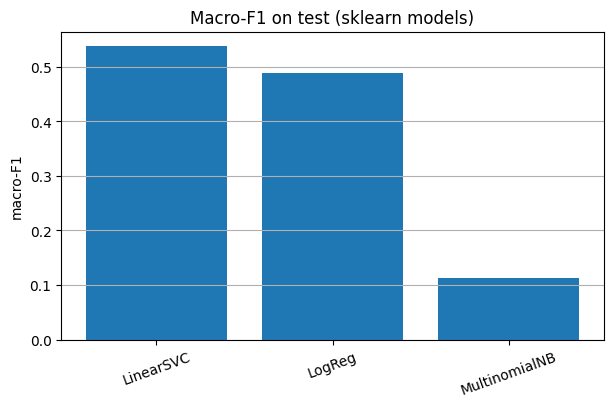

In [25]:
plt.figure(figsize=(7,4))
plt.bar(results_df["model"], results_df["macro_f1"])
plt.title("Macro-F1 on test (sklearn models)")
plt.xticks(rotation=20)
plt.ylabel("macro-F1")
plt.grid(axis="y")
plt.show()


### Task 7
**Bias-Variance Analysis**

Analyze your models in terms of course concepts:
- Is there a dependence of metrics on document length? Build graphs to answer the question.
- Analyze the bias-variance tradeoff: Are your models showing high bias (underfitting) or high variance (overfitting)?
- Compare train vs test performance. What does this tell you about generalization?
- If you observe overfitting, what could you do to reduce it? (e.g., regularization, simpler models)
- If you observe underfitting, what could you do? (e.g., more features, more complex models)


Оценим разрыв качества на train и test для лучшей модели (LinearSVC).
Macro-F1 на train 0.987
Macro-F1 на test 0.538
Разрыв 0.449

Это говорит о высокой вариативности и риске переобучения на малом датасете.
Также это подтверждается результатами Group cross-validation, где средняя macro-F1 0.420 и стандартное отклонение 0.231.

Связь качества и длины документа (точность по документам для LinearSVC):\
ru-10 длина 5156, accuracy 0.455\
ru-1004 длина 1085, accuracy 0.722\
ru-1017 длина 954,  accuracy 0.600

Видно, что на самом длинном документе точность самая низкая.\
Причина может быть в том, что в длинных текстах контекст вокруг сущности становится более разнообразным и менее шаблонным.\
На таком объёме данных нельзя делать сильный общий вывод, но наблюдение согласуется с графиком.


Best model = LinearSVC
macro-F1 train = 0.987
macro-F1 test  = 0.538
gap (train-test) = 0.449


,document_id,document_text,doc_len
133,bg-9,Лиляна Павлова: Нашата цел е ясна европейска п...,10148
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,5156
91,ru-1011,За Борисом Джонсоном последует сама Мэй - брит...,1640
73,ru-1004,Борис Джонсон ушел в отставку с поста главы МИ...,1085
58,ru-1017,Борис Джонсон подал в отставку с поста министр...,954
119,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,877
171,bg-29,Нов референдум за Брекзит няма да е недемократ...,778
44,ru-1001,Глава МИД Британии Борис Джонсон подал в отста...,688
109,ru-1003,09.07.2018 17:02 : Министр иностранных дел Вел...,490


,document_id,accuracy_on_doc,doc_len
0,ru-10,0.454545,5156
1,ru-1004,0.722222,1085
2,ru-1017,0.600000,954


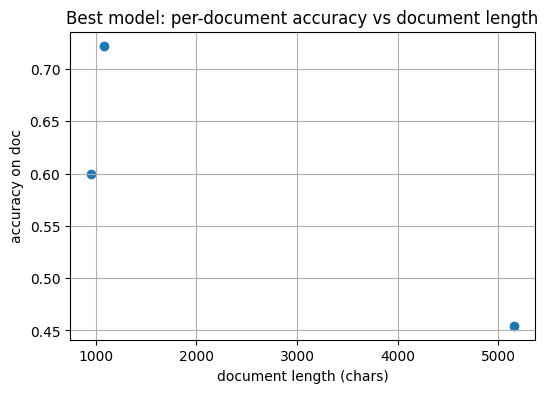

In [26]:
train_pred = best_model.predict(X_train)
test_pred  = best_model.predict(X_test)

f1_train = macro_f1_manual(y_train, train_pred, labels)
f1_test  = macro_f1_manual(y_test,  test_pred,  labels)

print(f"Best model = {best_name}")
print(f"macro-F1 train = {f1_train:.3f}")
print(f"macro-F1 test  = {f1_test:.3f}")
print(f"gap (train-test) = {f1_train - f1_test:.3f}")

doc_stats = df[["document_id","document_text"]].drop_duplicates()
doc_stats["doc_len"] = doc_stats["document_text"].astype(str).str.len()
display(doc_stats.sort_values("doc_len", ascending=False))

test_tmp = test_df.copy()
test_tmp["pred_best"] = test_pred
test_tmp["is_correct"] = (test_tmp["pred_best"] == test_tmp["gold_answer"]).astype(int)

per_doc = test_tmp.groupby("document_id")["is_correct"].mean().reset_index().rename(columns={"is_correct":"accuracy_on_doc"})
per_doc = per_doc.merge(doc_stats[["document_id","doc_len"]], on="document_id", how="left")
display(per_doc)

plt.figure(figsize=(6,4))
plt.scatter(per_doc["doc_len"], per_doc["accuracy_on_doc"])
plt.title("Best model: per-document accuracy vs document length")
plt.xlabel("document length (chars)")
plt.ylabel("accuracy on doc")
plt.grid(True)
plt.show()


### Task 8
**Error Analysis & Model Interpretation**

Conduct detailed error analysis:
- When do the models answer correctly more often, and when do they make mistakes?
- Analyze errors by entity type, document characteristics, etc.
- Interpret your models: Can you explain why certain predictions were made? (e.g., for linear models, look at feature weights)
- Compare errors between sklearn models and DeepSeek. What patterns do you see?
- Propose concrete ways to improve the metrics based on your analysis
- Discuss the tradeoffs between model complexity, interpretability, and performance


1) Основные путаницы по confusion matrix для LinearSVC\
LOC часто предсказывается как ORG (11 ошибок) и как PER (6 ошибок).\
ORG иногда предсказывается как PER (7 ошибок) и как LOC (2 ошибки).\
PER иногда предсказывается как ORG (2 ошибки) и как PRO (3 ошибки).

Самая проблемная зона это различение LOC и ORG на словах типа Британия, Европа, Брюссель, Лондон.\
Такие слова могут обозначать и географию, и институты в политическом контексте.

2) Примеры ошибок из test\
В тестовом документе ru-10 есть случаи, когда Альбиона и Британия (LOC) модель относит к PER или ORG.\
Также встречаются ошибки, где Еврокомиссия (ORG) предсказана как LOC.

3) Интерпретация признаков (по весам линейной модели)\
Топ признаки для EVT содержат Brexit и Брекзит, что логично для этого класса.\
Топ признаки для PER содержат имена и фамилии (Мэй, Джонсон, Барнье).\
Топ признаки для ORG содержат ЕС и Евросоюз.\
Топ признаки для LOC содержат названия городов и стран.

4) Почему DeepSeek лучше\
DeepSeek лучше справляется с неоднозначными случаями, потому что учитывает смысл фразы целиком, а не только совпадения токенов.\
При этом нужно помнить, что LLM может быть чувствительна к формулировке промпта.

5) Идеи улучшения baseline\
  Увеличить датасет или использовать больше документов из BSNLP\
  Добавить более точный контекст по позициям сущности из разметки, а не искать первое вхождение через find\
  Использовать языковые эмбеддинги (например fastText или ruBERT) и поверх них обучать линейный классификатор\
  Сделать оценку leave-one-document-out, чтобы уменьшить зависимость от конкретного разбиения


In [27]:
err_df = test_df.copy()
err_df["pred_best"] = test_pred
err_df["correct"] = (err_df["pred_best"] == err_df["gold_answer"]).astype(int)
display(err_df.sort_values("correct").head(25)[["document_id","entity","gold_answer","pred_best","context"]])
cm_best = confusion_matrix(y_test, test_pred, labels=labels)
cm_df = pd.DataFrame(cm_best, index=labels, columns=labels)
display(cm_df)
logreg = models["LogReg"]
feats = logreg.named_steps["feats"]
clf = logreg.named_steps["clf"]

word_names = feats.transformer_list[0][1].get_feature_names_out()
char_names = feats.transformer_list[1][1].get_feature_names_out()
feature_names = np.concatenate([word_names, char_names])

coef = clf.coef_
classes = clf.classes_

def show_top_features_for_class(class_label: str, top_k: int = 10):
    ci = list(classes).index(class_label)
    weights = coef[ci]
    top_idx = np.argsort(weights)[-top_k:][::-1]
    return [(feature_names[i], float(weights[i])) for i in top_idx]

for cls in classes:
    print("\nClass", cls, "top features:")
    for feat, w in show_top_features_for_class(cls, top_k=10):
        print(f"  {feat:30s} {w:+.3f}")


,document_id,entity,gold_answer,pred_best,context
1,ru-10,Альбиона,LOC,PER,"оворщику Брюсселя по ""брекзиту"". - От ред.)"". ..."
2,ru-10,Альбионе,LOC,ORG,ступки со стороны бывших коллег по единой Евро...
5,ru-10,Британия,LOC,ORG,", чтобы она оставила Северную Ирландию в соста..."
4,ru-10,Британии,LOC,ORG,ыйдет победителем. Фаворит букмекеров в качест...
6,ru-10,Брюсселе,LOC,ORG,"хожие по составу с государственной изменой, не..."
7,ru-10,Брюсселем,LOC,PER,"и британцам, ни европейцам. Так, оппозиционные..."
9,ru-10,Брюсселю,LOC,PER,дущего торгового договора с единой Европой Лон...
8,ru-10,Брюссель,LOC,EVT,"жонсона, что Британия может потерять Северную ..."
10,ru-10,Брюсселя,LOC,ORG,"нсона, ""Лондон обернул британскую конституцию ..."
14,ru-10,Еврокомиссия,ORG,LOC,"уга ""на слабо"", британский бизнес создает запа..."


,PER,ORG,LOC,EVT,PRO
PER,17,2,0,1,3
ORG,7,10,2,1,0
LOC,6,11,8,1,0
EVT,0,0,1,6,0
PRO,0,0,0,0,1



Class EVT top features:
  brexit context                 +0.606
  brexit                         +0.588
  брекзит                        +0.509
  българското председателство    +0.414
  брекзита                       +0.366
  брекзит context                +0.345
  българското                    +0.329
   брек                          +0.286
  екз                            +0.286
  кзи                            +0.286

Class LOC top features:
  великобритании context         +0.332
  ове                            +0.229
  се                             +0.210
  софия                          +0.203
  димитровград                   +0.203
  боровец                        +0.201
  козлодуй                       +0.200
  русе                           +0.199
  бургас                         +0.198
  пловдив                        +0.198

Class ORG top features:
  ес context                     +0.384
  евросоюза                      +0.333
  европейския                    +0.245
  евр

### Task 9
**Conclusions & Reflection**

Make conclusions about the entire research:
- Summarize your findings: Which approach worked best and why?
- Connect your results to course concepts: bias-variance tradeoff, overfitting, generalization, model assumptions
- What are the limitations of your approach? What assumptions did you make?
- What would you do differently if you had more time or data?
- Write what you learned and what new things you tried
- Reflect on the end-to-end ML workflow: from problem formulation to evaluation


### Task 9 — Conclusions and Reflection

1) Итоговые результаты\
Лучший sklearn baseline это LinearSVC:\
accuracy 0.545\
macro-F1 0.538\
DeepSeek на том же тестовом наборе:\
accuracy 0.831\
macro-F1 0.740\

2) Главные причины разницы\
   Очень мало данных для обучения классических моделей (107 train примеров и 6 документов)\
   Классы распределены неравномерно, особенно редкие EVT и PRO\
   LLM опирается на знания и семантику из предобучения, что помогает на малых данных и на политическом контенте

3) Bias and variance
Разрыв между train и test для LinearSVC большой (macro-F1 0.987 против 0.538).\
 Это признак высокой дисперсии и того, что модель легко подстраивается под train.
Group cross-validation также показывает нестабильность, стандартное отклонение 0.231.

4) Ограничения эксперимента\
  Всего 9 документов, поэтому любая оценка сильно зависит от того, какие документы попали в test\
  Редкие классы дают нестабильные метрики, особенно когда в test всего 1 пример класса\
  Метрики DeepSeek зависят от промпта, но в этом решении промпт зафиксирован

5) Что дальше\
Расширил бы датасет на большее число документов и языков\
Добавил более надёжный способ извлечения контекста по span координатам из разметки\
Добавил модели на эмбеддингах, чтобы уменьшить зависимость от конкретных словоформ\
Отдельно исследовал ошибки LOC и ORG и попытался добавить признаки, отражающие синтаксис и устойчивые выражения


## Экспорт результатов
Сохраняем CSV `predictions_test.csv` с предсказаниями моделей (и DeepSeek, если ответы есть).

In [28]:
out = test_df.copy()
out["row_id"] = np.arange(len(out), dtype=int)

for name, model in models.items():
    out[f"pred_{name}"] = model.predict(X_test)

deepseek_path = Path("deepseek_answers_test.csv")
if deepseek_path.exists():
    ds = pd.read_csv(deepseek_path)
    ds["row_id"] = ds["row_id"].astype(int)
    ds["pred_deepseek"] = ds["deepseek_raw"].apply(normalize_deepseek_label)
    out = out.merge(ds[["row_id","pred_deepseek"]], on="row_id", how="left")

csv_path = Path("predictions_test.csv")
out.to_csv(csv_path, index=False)
print("Saved:", csv_path.resolve())
display(out.head(10))


Saved: /content/predictions_test.csv


,document_id,document_text,entity,gold_answer,context,ml_text,row_id,pred_LinearSVC,pred_LogReg,pred_MultinomialNB,pred_deepseek
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Brexit,EVT,Тереза Мэй рассчитывает усидеть в седле до зав...,Brexit \nCONTEXT: Тереза Мэй рассчитывает усид...,0,EVT,EVT,PER,EVT
1,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Альбиона,LOC,"оворщику Брюсселя по ""брекзиту"". - От ред.)"". ...","Альбиона \nCONTEXT: оворщику Брюсселя по ""брек...",1,PER,ORG,ORG,LOC
2,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Альбионе,LOC,ступки со стороны бывших коллег по единой Евро...,Альбионе \nCONTEXT: ступки со стороны бывших к...,2,ORG,ORG,PER,LOC
3,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Борис Джонсон,PER,едителем. Фаворит букмекеров в качестве возмож...,Борис Джонсон \nCONTEXT: едителем. Фаворит бук...,3,PER,PER,PER,PER
4,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Британии,LOC,ыйдет победителем. Фаворит букмекеров в качест...,Британии \nCONTEXT: ыйдет победителем. Фаворит...,4,ORG,PER,PER,PRO
5,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Британия,LOC,", чтобы она оставила Северную Ирландию в соста...","Британия \nCONTEXT: , чтобы она оставила Север...",5,ORG,ORG,PER,ORG
6,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Брюсселе,LOC,"хожие по составу с государственной изменой, не...",Брюсселе \nCONTEXT: хожие по составу с государ...,6,ORG,ORG,PER,LOC
7,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Брюсселем,LOC,"и британцам, ни европейцам. Так, оппозиционные...","Брюсселем \nCONTEXT: и британцам, ни европейца...",7,PER,PER,PER,LOC
8,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Брюссель,LOC,"жонсона, что Британия может потерять Северную ...","Брюссель \nCONTEXT: жонсона, что Британия може...",8,EVT,LOC,PER,LOC
9,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Брюсселю,LOC,дущего торгового договора с единой Европой Лон...,Брюсселю \nCONTEXT: дущего торгового договора ...,9,PER,LOC,PER,LOC
